In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import json

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

params = json.loads(open('../params.json', 'r').read())

# Date range
start = "2023-01-10"
end = "2023-04-10"

# Tickers of assets
OIL = 'Oil gas biofuels, exploration, refining etc'
TELCO = 'Telecommunications'
PULP_PAPER = 'Pulp and Paper'
ELECTRICAL = 'Electrical energy'
MINERALS = 'Minerals'

assets = ['TAEE11.SA', 'CPFE3.SA', 'EGIE3.SA']

# Downloading data
data = yf.download(assets, start = start, end = end)

data = data.loc[:,('Adj Close', slice(None))]

data.columns = assets

[*********************100%%**********************]  3 of 3 completed


In [2]:
# Calculating returns
Y = data[assets].pct_change().dropna()

display(Y.tail())

,TAEE11.SA,CPFE3.SA,EGIE3.SA
Date,,,
2023-03-31,-0.6591%,-0.4461%,-0.0574%
2023-04-03,0.0632%,-1.2696%,-0.5168%
2023-04-04,2.2734%,1.4372%,1.5296%
2023-04-05,0.3087%,-0.6214%,0.0000%
2023-04-06,1.6928%,0.4252%,-0.3695%


,CPFE3.SA
0,100.0000%


Total: 99.9999788500087
Symbols: ['CPFE3.SA']


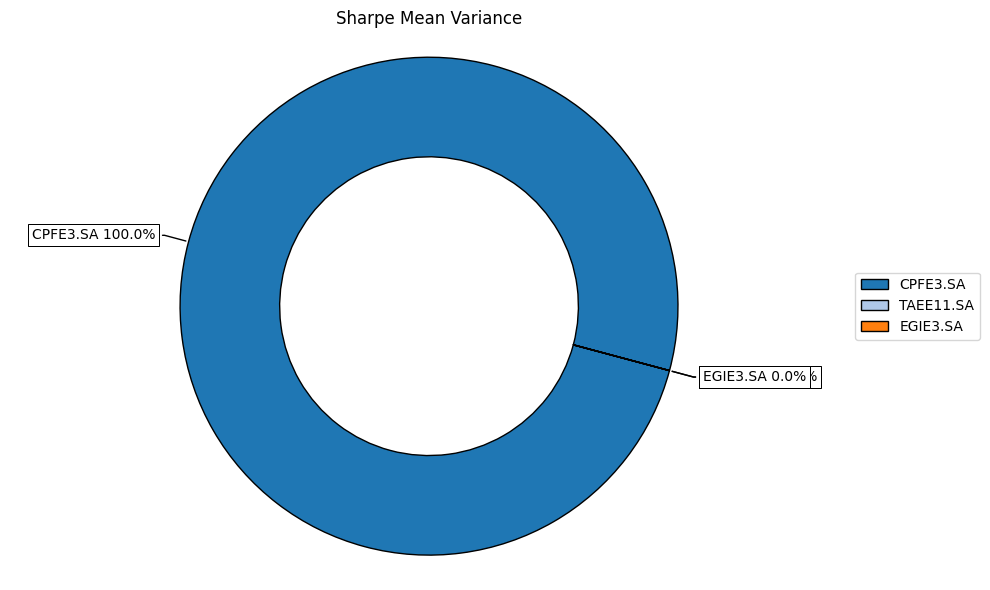

In [3]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w_sharpe = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

#display(w_sharpe.T)
keys = w_sharpe.T.keys()
filtered_keys= []
w_sharpe_filtered_weights_raw = []
total_w_sharpe_filtered_weights = 0
for key in keys:
    if w_sharpe.T[key]["weights"] > 0.01:
        filtered_keys.append(key)
        w_sharpe_filtered_weights_raw.append(w_sharpe.T[key]["weights"])
        total_w_sharpe_filtered_weights += w_sharpe.T[key]["weights"]

w_sharpe_filtered_weights = pd.DataFrame([w_sharpe_filtered_weights_raw], columns=filtered_keys)
display(w_sharpe_filtered_weights)
print(f"Total: {total_w_sharpe_filtered_weights*100}")
print(f"Symbols: {[key for key in filtered_keys]}")

# Plotting the composition of the portfolio

ax_sharpe = rp.plot_pie(w=w_sharpe, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

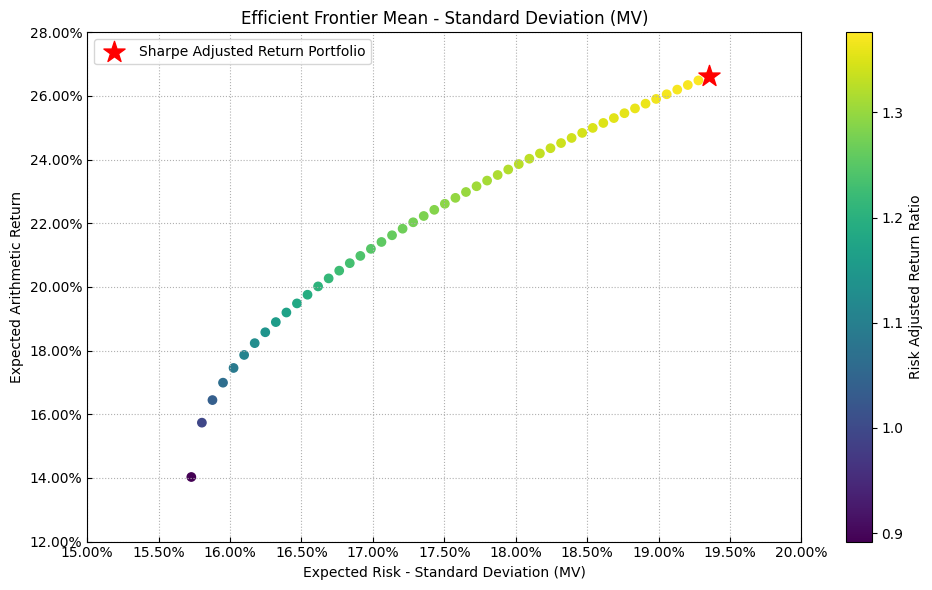

In [4]:
# Plotting frontier

points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)
# display(frontier.T.tail())

# Plotting the efficient frontier

label = 'Sharpe Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w_sharpe, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)


In [5]:
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

In [6]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,WR,MDD,ADD,CDaR,UCI,EDaR
TAEE11.SA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
CPFE3.SA,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%
EGIE3.SA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


,TAEE11.SA,CPFE3.SA,EGIE3.SA
weights,0.0000%,30.3462%,69.6538%


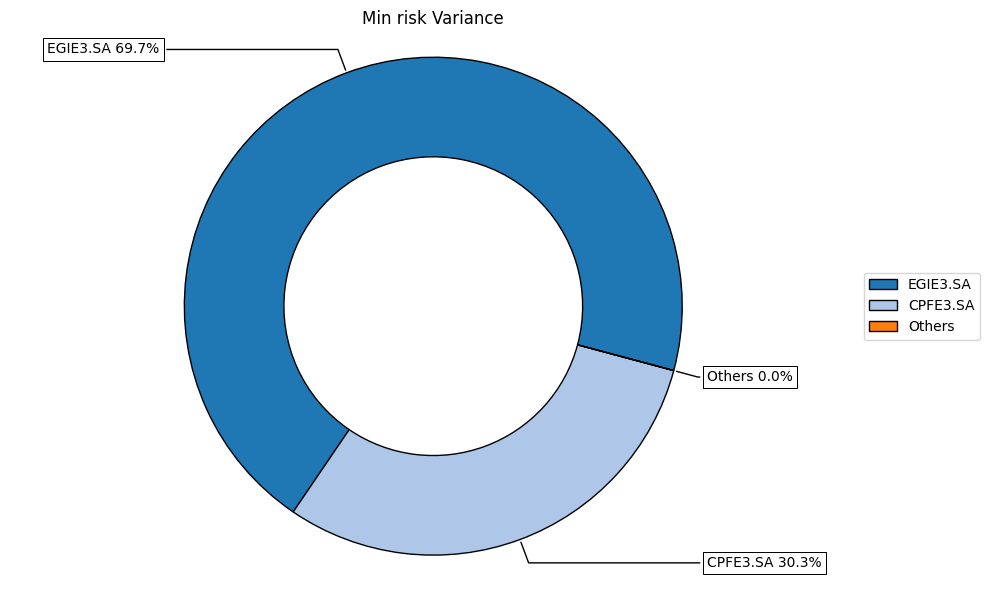

In [7]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'MinRisk' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w_min_risk = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w_min_risk.T)


# Plotting the composition of the portfolio

ax_min_risk = rp.plot_pie(w=w_min_risk, title='Min risk Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

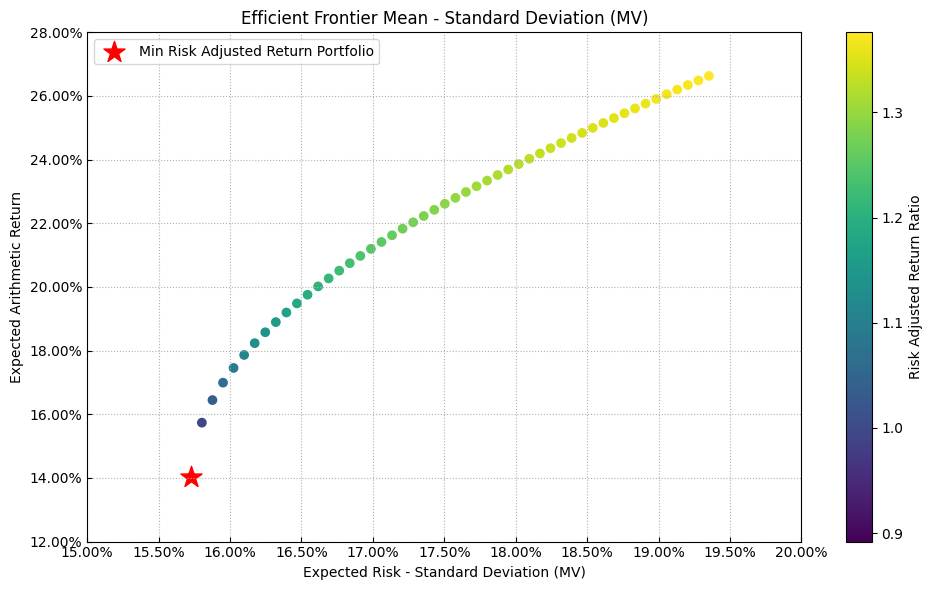

In [8]:
# Plotting frontier

points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)
# display(frontier.T.tail())

# Plotting the efficient frontier

label = 'Min Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w_min_risk, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)


In [9]:
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

In [10]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,WR,MDD,ADD,CDaR,UCI,EDaR
TAEE11.SA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,2.97%,11.34%,0.00%,0.00%,0.00%,0.00%,0.00%
CPFE3.SA,30.35%,12.75%,30.02%,15.09%,40.75%,54.09%,97.03%,88.66%,100.00%,91.99%,100.00%,100.00%,100.00%
EGIE3.SA,69.65%,87.25%,69.98%,84.91%,59.25%,45.91%,0.00%,0.00%,0.00%,8.01%,0.00%,0.00%,0.00%
